# CSP based classification

Common spatial pattern (CSP) is a technique often used in Motor Imagery (MI) EEG-based BCIs to extract characteristic neural features from epochs.
These features can then be used as input for more traditional Machine Learning (ML) methods to obtain a minimal working BCI pipeline, although filtering of the signal before using CSP is also recommended.
CSP projects the multi-channel EEG data onto a lower-dimensional spatial subspace by using a projection matrix.
This process is capable of maximizing the variance between the different classes and thus makes more information-carrying features than plain RAW EEG data ([Bhattacharyya et al](https://doi.org/10.1016/B978-0-12-821413-8.00017-8)).

According to ([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)), the desired frequency band for MI classification is 8-30 Hz. 
This includes the Alpha (8-13 Hz) and Beta (14-30 Hz) waves.
To do such a filtering, band-pass filters are recommended, of which there exist different approaches.
([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)) used a third-order Butterworth band-pass filter for this.
([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)) also goes into further depth on the working of CSP, a technique first used by Ramoser et al [2000](10.1109/86.895946) to classify MI data but already known to exist for EEG with the first mentions by [Koles et al](https://doi.org/10.1007/BF01129656).

In this notebook, we explore this CSP technique for feature generation and combine it with a wide variety of datasets and classification algorithms in multiple small pipelines.
This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in previous notebooks. Since the original dataset by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) was provided in MatLab files, FIF files for the python MNE datatypes are made available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

We rely in part on the [MNE provided tutorials](https://mne.tools/dev/auto_examples/decoding/index.html) for this notebook.

## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- A word on filtering and CSP
- Band-pass filter to CSP to LDA pipeline
  - Fixed window classification: Single trial | CSP + LDA | Binary left-right MI task
  - Fixed window classification: Single trial | CSP + LDA | three class MI task
  - Fixed window classification: Multi trial | CSP + LDA | three class MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | three class MI task

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules and show if the versions match those that are recommended.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Scikit-learn version (1.0.2 recommended): 1.0.2
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. FIF files from this same dataset are also made available in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). A check on the availability of these two datasets is performed below.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data.
The loaded data is that of a specific subject and thus can exist of multiple MNE RAW objects.
This list of objects is provided as well as a singular one, namely the first of the list.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [4]:
####################################################
# LOADING RAW MNE DATA AND EPOCS
####################################################

# You can specify the data file to use here, per default it is CLASubjectB1512153StLRHand
subject = "C"

# Load RAW MNE
mne_raws = CLA_dataset.get_raw_mne_data_for_subject("C")
mne_raw = mne_raws[0]
print(f"Loaded MNE raw for subject {subject}: {len(mne_raws)} files, last file: \n")
display(mne_raw)



Loaded MNE raw for subject C: 3 files, last file: 



<Raw | CLASubjectC1511263StLRHand_raw.fif, 21 x 666800 (3334.0 s), ~37 kB, data not loaded>

<hr><hr>

## A word on filtering and CSP

At the beginning of this notebook, a short explanation of filtering and CSP is already given.
As these are very important concepts, some more details are given here, mainly based on the work by ([Bhattacharyya et al](https://doi.org/10.1016/B978-0-12-821413-8.00017-8)) and ([Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9)).

The raw EEG data of the CLA dataset used in this notebook is recorded at a sampling frequency of 200Hz.
According to Nyquist's theorem, this enables the reliable detection of a periodic signal with a frequency of at most 100Hz.
Luckily, MI data relies mostly on Alpha and Beta waves.
Alpha and beta waves are often specified as being from 8-12Hz whilst Beta waves are said to be from 12–35Hz.
However, the exact distributions are not agreed upon and the frequencies to include for the MI classification task vary in the field.
According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz.
[Kirar and Agrawal](10.1109/SSCI.2018.8628719) specify it is as 7-30Hz and variations are seen up to 0-40Hz.
This should ideally be part of the training when working on a patient per patient basis ([Blankertz et al](10.1016/j.neuroimage.2007.01.051)).
Besides filtering the data, making a subselection of the electrodes is often also performed to reduce the dimensionality and thus the complexity of the data further.

Common spatial pattern (CSP) is a technique used in Motor Imagery (MI) EEG-based BCIs to extract characteristic neural features from epochs.
CSP is proven to be a computationally simple data-driven spatial filtering technique that offers great results and can be easily implemented through libraries such as [MNE](https://doi.org/10.1016/j.neuroimage.2013.10.027).
Being data-driven, CSP is noise sensitive and requires sufficient samples to perform well.
Nonetheless, the ease of use makes it a popular approach in the field to generate features used for training more traditional Machine Learning (ML) classifiers such as Support Vector Machines (SVMs), Random Forest (RF) and K Nearest Neighbours (KNN) amongst others.
CSP was originally meant to be used in binary settings, however, multiclass variants have been proposed and are widely used as well, MNE uses the multi-class approach by [Grosse-Wentrup and Buss](10.1109/TBME.2008.921154).
Many variants of CSP exist as well, some are shown to perform up to 10% better for users where CSP has poor performance [Lotte and Guan](10.1109/ICPR.2010.904).

CSP is thoroughly explained by [Blankertz et al](10.1109/MSP.2008.4408441), where variants and optimisation tricks are also discussed.
As discussed, regular CSP is a binary method to analyze multichannel data based on recordings from two classes ([Blankertz et al](10.1109/MSP.2008.4408441)).
[Blankertz et al](10.1109/MSP.2008.4408441) goes into further details on the math.
In essence, CSP aims to maximize the variance of the spatially filtered signal for one class whilst minimizing it for the other class ([Blankertz et al](10.1109/MSP.2008.4408441)).
Since CSP relies on band power, appropriate band-pass filtering before using CSP is recommended to extract MI specific waves.



<hr><hr>

## Band-pass filter to CSP to LDA pipeline

We first combine a band-pass filter with Common Spatial Patterns (CSP) and Linear Discriminant Analysis (LDA) to form a first minimal BCI pipeline.
We do this in a variety of ways.

<hr>

### Fixed window classification: Single trial | CSP + LDA | Binary left-right MI task

We start with fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We use overlap-add FIR filtering to extract more MI specific frequencies.

Since CSP was originally meant to be used in a binary setting, we start with a binary variant of the CLA dataset only containing `task/left` and `task/right`.
The CSP configuration is manually hyper-tuned to see how it evolves using different settings.

We then use a non-hyper-tuned LDA for the classification of these features.

The found classification results for subject `C` are:
- Using file at index 0
  - Performed cross fold validation and got an average classification score of 0.9654450261780104 with a standard deviation of 0.006282722513089026
  - Fitted pipeline a single time and got a classification accuracy of 0.9842931937172775
- Using file at index 1
  - Performed cross fold validation and got an average classification score of 0.9298429319371728 with a standard deviation of 0.019757028548809626
  - Fitted pipeline a single time and got a classification accuracy of 0.9109947643979057
- Using file at index 2
  - Performed cross fold validation and got an average classification score of 0.8638743455497382 with a standard deviation of 0.022701029726365233
  - Fitted pipeline a single time and got a classification accuracy of 0.8167539267015707

From this we can see the inter-patient variance is significantly large.



In [5]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to binary classification
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Loading data for 636 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:



Number of events,636
Events,task/left: 322task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Got the band-pass filtered epochs: 



Number of events,636
Events,task/left: 322task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Extracted labels from epochs: [1 2 1 1 2 2 2 1 1 2]


Performed cross fold validation and got an average classification score of 0.9654450261780104 with a standard deviation of 0.006282722513089026
Fitted pipeline a single time and got a classification accuracy of 0.9842931937172775


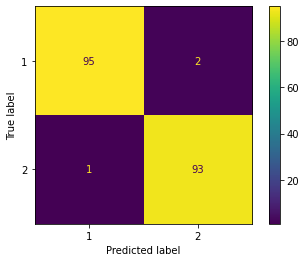

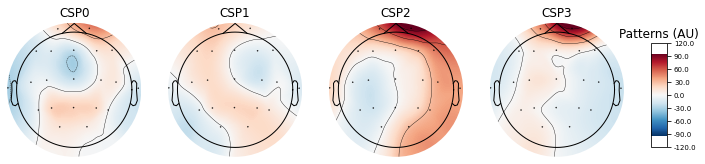

In [6]:
####################################################
# FIXED WINDOW: CSP + LDA (BINARY)
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=4,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [7]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Single trial | CSP + LDA | three class MI task

We continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We now include all three MI tasks from the CLA dataset, this includes `task/neutral` next to the previous `task/left` and `task/right`.
The CSP configuration is adopted from before but the amount of components is increased to 6, following the reasoning that there also was a 50% increase in classes.

We then use a non-hyper-tuned LDA for the classification of these features.

The found classification results for subject `C` are:
- Using file at index 0
  - Performed cross fold validation and got an average classification score of 0.8666666666666666 with a standard deviation of 0.011744121198116483
  - Fitted pipeline a single time and got a classification accuracy of 0.8854166666666666
- Using file at index 1
  - Performed cross fold validation and got an average classification score of 0.7881944444444445 with a standard deviation of 0.04275206658783718
  - Fitted pipeline a single time and got a classification accuracy of 0.7569444444444444
- Using file at index 2
  - Performed cross fold validation and got an average classification score of 0.7118055555555556 with a standard deviation of 0.01388888888888889
  - Fitted pipeline a single time and got a classification accuracy of 0.5902777777777778

From this we can see the inter-patient variance is significantly large.



In [8]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Loading data for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Got the band-pass filtered epochs: 



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


Performed cross fold validation and got an average classification score of 0.8666666666666666 with a standard deviation of 0.011744121198116483
Fitted pipeline a single time and got a classification accuracy of 0.8854166666666666


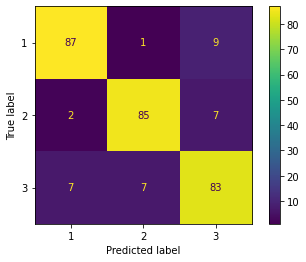

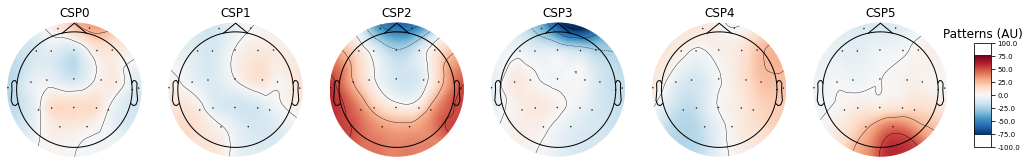

In [9]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [10]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Multi trial | CSP + LDA | three class MI task

The previous results were statisfactory but for one trial only.
This is bound to give an over estimation of real-life performance where multiple trials exist.
The fixed window and some other aspects are also unrealistic but are kept for now to see the individual impact.


Thus, we continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
But we combine the epochs of all trials from the patient, which introduces variability and will likely decrease performance of the model.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We still include all three MI tasks from the CLA datases (`task/neutral`, `task/left` and `task/right`).
The CSP configuration is adopted from before as well, having 6 components.

We still use a non-hyper-tuned LDA for the classification of these features.



In [11]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels = []

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    epochs.append(mne_fixed_window_epochs)
    print(f"Loaded and filtered epochs")
    
    # Labels: should be integers!
    labels.extend(mne_fixed_window_epochs.events[:, -1])
    print(f"Extracted labels from epochs")
    
# Make single epoch object
mne_fixed_window_epochs = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated all epochs")
display(mne_fixed_window_epochs)
display(mne_fixed_window_epochs.info)
print(f"\n\nTotal amount of labels: {len(labels)}")

# Remove unused variables
del epochs
del single_mne_raw



Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


Loaded raw data
Loaded and filtered epochs
Extracted labels from epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_15308/2817143996.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs = mne.concatenate_epochs(epochs, verbose=False)




Concatenated all epochs


Number of events,2879
Events,task/left: 965task/neutral: 972task/right: 942
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>



Total amount of labels: 2879


Performed cross fold validation and got an average classification score of 0.7145833333333333 with a standard deviation of 0.005791664816294806
Fitted pipeline a single time and got a classification accuracy of 0.7465277777777778


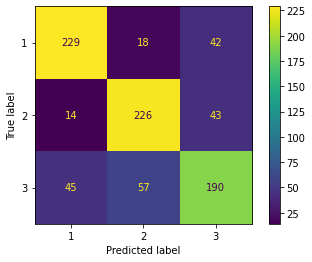

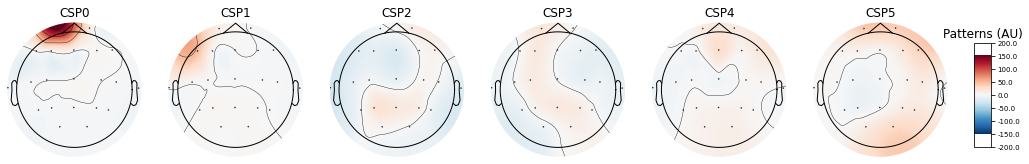

In [12]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [13]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | three class MI task

The previous results were statisfactory for multi-trial classification.
However, the train/test split happened over all trials and thus training data from all trials is available.
More realisticly We should have train and test trials.

All other settings remain unchanged from the previous experiment.
Thus, we continue using fixed window epochs consisting of 0.2 to 0.7 seconds after the marker was shown on the screen.
We still use overlap-add FIR filtering to extract more MI specific frequencies.

We still include all three MI tasks from the CLA datases (`task/neutral`, `task/left` and `task/right`).
The CSP configuration is adopted from before as well, having 6 components.

We still use a non-hyper-tuned LDA for the classification of these features.

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on seperate test trial of: 0.7333333333333333
- Using index 1 as test and others as train:
  - Found accuracy on seperate test trial of: 0.621875
- Using index 2 as test and others as train:
  - Found accuracy on seperate test trial of: 0.3899895724713243
- Using index 0 as test and training on index 1:
  - Found accuracy on seperate test trial of: 0.7145833333333333
- Using index 1 as test and training on index 0:
  - Found accuracy on seperate test trial of: 0.6635416666666667


Again, we notice huge differences in performance.



In [14]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated train epochs")
display(mne_fixed_window_epochs_train)
display(mne_fixed_window_epochs_train.info)
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nTest epochs")
display(mne_fixed_window_epochs_test)
display(mne_fixed_window_epochs_test.info)
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw



Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated train epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_15308/3187648474.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,1919
Events,task/left: 643task/neutral: 648task/right: 628
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1512163StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-12-16 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 1919


Test epochs


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_15308/3187648474.py:53: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectC1511263StLRHand.mat | age 30| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 32.0 Hz
 meas_date: 2015-11-26 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

Total amount of train labels: 960


Found accuracy on seperate test trial of: 0.7333333333333333


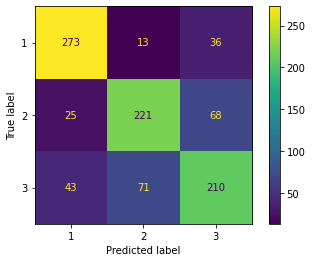

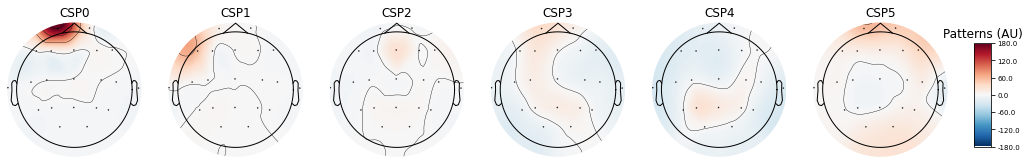

In [15]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline on the train trial(s)
    csp_lda_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_lda_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on seperate test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_lda_pipeline
del labels_test_predict
del lda
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test


In [16]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_train
del labels_test
del labels_train